In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch  as th
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle
import pandas as pd
import seaborn as sns
import random
from tqdm import tqdm
from transformers import Wav2Vec2Model
from torch.utils.data import TensorDataset, DataLoader
import copy


In [2]:
###### Set the device to use Apple M1 GPU #######
device = th.device('mps')

In [92]:
class RandomProjectionQuantizer(nn.Module):
    def __init__(self, input_dim, quantizer_dim, codebook_size, random_state=None, device='cpu'):
        super().__init__()
        self.random_projection = nn.Linear(input_dim, quantizer_dim, bias=False)
        nn.init.xavier_uniform_(self.random_projection.weight)

        self.code_book = nn.Parameter(th.randn(quantizer_dim, codebook_size)).to(device).detach().requires_grad_(False)

        self.random_projection.weight.requires_grad = False
        #self.code_book.requires_grad = False

        self.device = device
        if random_state is not None:
            th.manual_seed(random_state)

    @th.no_grad()
    def forward(self, input_values: th.Tensor, mask_time_indices: th.Tensor) -> th.Tensor:
        """
        Args:
            input_values (torch.Tensor): with shape `(B, L, D)`
            mask_time_indices (torch.Tensor): with shape `(B, L)`

        Returns:
            torch.Tensor with shape `(N)`

        """
        shape = input_values.shape
        targets = self.random_projection(input_values)

        repeated_code_book = self.code_book.unsqueeze(0).unsqueeze(0).expand(shape[0], shape[1], -1, -1)

        # Effectuer l'opération de soustraction
        vector_distances = th.norm(targets.unsqueeze(-1).expand_as(repeated_code_book) - repeated_code_book, dim=2)


        labels = th.argmin(vector_distances, dim=-1)

        return labels

class ConformerModel(nn.Module):
    def __init__(self, input_size=600, hidden_size=64, output_size=192):
        super(ConformerModel, self).__init__()

        # Couches Conformer
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.attention = ConformerAttention(hidden_size)
        self.linear3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.attention(x)
        x = self.linear3(x)
        return x

class ConformerAttention(nn.Module):
    def __init__(self, hidden_size):
        super(ConformerAttention, self).__init__()
        self.linear1 = nn.Linear(hidden_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)

    def forward(self, x):
        # Position-wise feed-forward networks
        residual = x
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        # Add residual connection
        x += residual
        return x

class BestRqFramework(nn.Module):
    def __init__(self, encoder: nn.Module, num_temporal_dimension_reduction_steps: int, input_feature_size: int, encoder_hidden_size: int, num_code_books: int,
                 mask_time: int, stride_time: int, random_state : int, mask_prob: float = 0.1, batch_size : int = 200, num_masks_per_signal :int = 5):
        super().__init__()
        self.K = num_temporal_dimension_reduction_steps
        self.random_state = random_state
        self.batch_size = batch_size
        self.layer_norm = nn.LayerNorm(input_feature_size)
        self.random_projection_quantizer = RandomProjectionQuantizer(input_feature_size, encoder_hidden_size, num_code_books, random_state = random_state)
        self.encoder = encoder
        self.out_linear = nn.Linear(192, 1)
        self.num_time_steps = int(mask_time // (stride_time * self.K))
        self.mask_prob = mask_prob
        self.mask_time = mask_time
        self.num_masks_per_signal = num_masks_per_signal

    def split_batch(self, X, y):
        dataset = TensorDataset(X, y)
        data_loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        return data_loader


    def forward(self, input_values: th.Tensor):
        """
        Args:
            input_values (th.Tensor): with shape `(B, T, D)`

        Returns:

        """

        input_values = self.layer_norm(input_values)

        masked_input_values, time_mask_indices = self.masking(input_values.clone())

        labels = self.random_projection_quantizer(input_values, time_mask_indices)

        encoder_out = self.encoder(masked_input_values)

        targets = encoder_out[time_mask_indices]

        targets_out = self.out_linear(targets)

        return targets_out, labels[time_mask_indices == 1]



    def masking(self, input_tensor, min_mask=0):
        """
        Generate a mask to randomly mask a subset of values based on the input tensor and probability.

        Args:
        - input_tensor (torch.Tensor): Input tensor for which the mask needs to be generated.
        - prob (float): Probability of masking each valid position.
        - min_mask (float): Minimum number of positions to mask.

        Returns:
        - subset_mask (torch.Tensor): Binary mask indicating positions to be masked (True) and positions to be kept (False).
        """
        batch, seq, device = *input_tensor.shape[:-1], input_tensor.device
        seq_mask = th.ones((batch, seq), dtype=th.bool, device=device)  # Assume all positions are valid

        num_to_mask = (seq_mask.sum(dim=-1, keepdim=True) * self.mask_prob).clamp(min=min_mask)
        logits = th.rand((batch, seq), device=device)
        logits = logits.masked_fill(~seq_mask, -1)

        randperm = logits.argsort(dim=-1).float()

        num_padding = (~seq_mask).sum(dim=-1, keepdim=True)
        randperm -= num_padding

        subset_mask = randperm < num_to_mask
        subset_mask.masked_fill_(~seq_mask, False)
        masked_tensor = input_tensor.clone()
        values_to_change = masked_tensor[subset_mask].clone()
        shape = values_to_change.shape
        for _ in range(self.num_masks_per_signal):
            idx = random.randint(0, int(shape[1]))
            if idx + self.mask_time <= shape[1]:
                values_to_change[:, idx:idx+self.mask_time] = th.normal(mean = 0, std = 0.1, device = device, size= (shape[0], self.mask_time))
        masked_tensor[subset_mask] = values_to_change
        return masked_tensor, subset_mask

In [106]:
def pretrain(trainloader,model, epochs=10, lr = 1e-3):

        optimizer = optim.Adam(model.encoder.parameters(), lr= lr)
        loss_function = nn.MSELoss(reduction='mean')
        # Iterate over epochs
        for epoch in tqdm(range(epochs)):
            epoch_loss = 0.0

            for inputs, _ in trainloader:

                # Zero gradients
                optimizer.zero_grad()

                inputs = inputs.view(1, -1, 600).to(device)
                # Forward pass
                encoder_outs, labels = model(inputs)

                # Compute loss
                loss = loss_function(encoder_outs, labels.float().view(-1, 1))

                # Backward pass
                loss.backward()

                # Update weights
                optimizer.step()

                epoch_loss += loss.item()

            # Print epoch loss
            print(f"Pretraining Epoch {epoch+1}/{epochs}, Loss: {epoch_loss / len(xtrain)}")


In [3]:
filepath = 'data/cassette-th-data.pck'
xtrain, xvalid, ytrain, yvalid = np.load(filepath, allow_pickle = True)
input_dim = xtrain[0].shape
input_dim[0], xtrain.shape

(600, torch.Size([175995, 600]))

In [4]:
device = 'cpu'
tmp = RandomProjectionQuantizer(input_dim= 600, quantizer_dim= 100, codebook_size= 20,random_state= 2673834267383, device = device)
input_size = (175995, 600)
mask_time_indices = th.ones(input_size[0], input_size[1], dtype=th.bool, device= device).to(device)
mask_time_indices = mask_time_indices.view(-1, input_size[1]).unsqueeze(0)
xtrain_batched = xtrain.unsqueeze(0).to(device)
results  = tmp(xtrain_batched, mask_time_indices)
results

tensor([[17,  9,  8,  ..., 18, 17,  7]])

In [93]:
model = BestRqFramework(encoder= ConformerModel(),
                        num_temporal_dimension_reduction_steps=100,
                        input_feature_size=600,
                        encoder_hidden_size=20,
                        num_code_books=10,
                        mask_time= 50,
                        stride_time=1,
                        random_state=42,
                        mask_prob=0.1,
                        batch_size=200)


inputs = xtrain[:200].to(device).view(-1, 200, 600)
    # `(batch size)` Number of available time steps per batch
input_lengths = th.tensor([200, 871, 389, 487]).to(device)

input_values, idx = model(inputs)


Text(0.5, 1.0, 'Visualisation du masque')

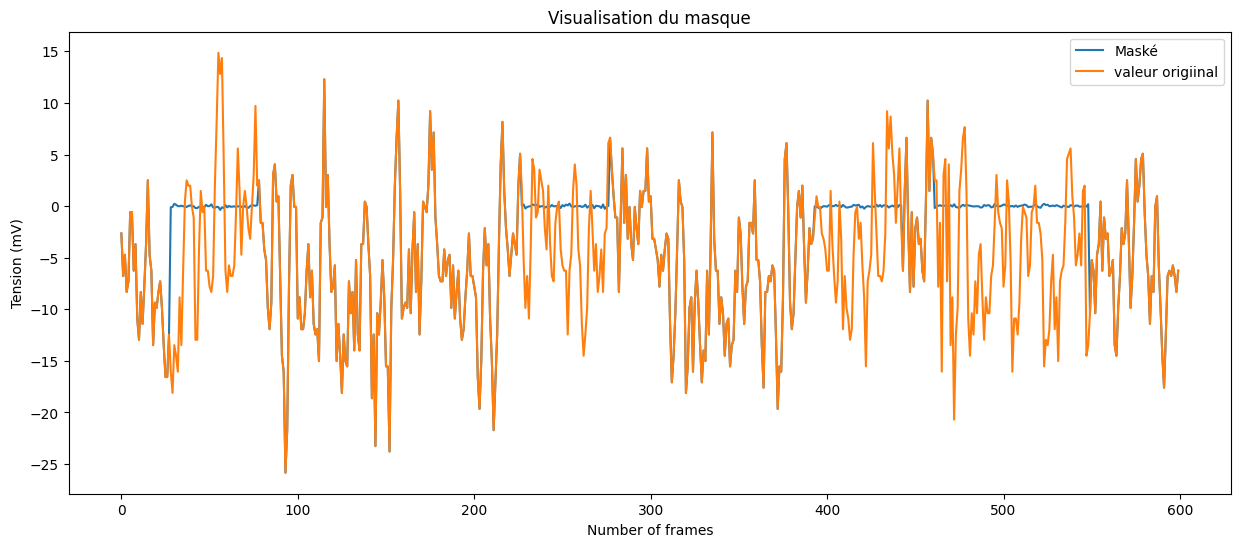

In [54]:
#Viz of the mask

model = BestRqFramework(encoder= ExampleEncoder(),
                        num_temporal_dimension_reduction_steps=100,
                        input_feature_size=600,
                        encoder_hidden_size=20,
                        num_code_books=10,
                        mask_time= 50,
                        stride_time=1,
                        random_state=42,
                        mask_prob=1,
                        batch_size=200)

masked_values,_ = model.masking(inputs)



plt.figure(figsize=(15,6))
for i in range(1):
    plt.plot(masked_values[0,i,:].detach().numpy(), label = 'Maské')
    plt.plot(inputs[0, i ,:].detach().numpy(), label ='valeur origiinal')
plt.legend()
plt.xlabel('Number of frames')
plt.ylabel('Tension (mV)')
plt.title('Visualisation du masque')


In [107]:
dataset = TensorDataset(xtrain, ytrain)
data_loader = DataLoader(dataset, batch_size= 200, shuffle=True)
pretrain(data_loader, model)

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:04<00:42,  4.75s/it]

Pretraining Epoch 1/10, Loss: 0.02466334437148104


 20%|██        | 2/10 [00:09<00:37,  4.66s/it]

Pretraining Epoch 2/10, Loss: 0.02469508982730212


 30%|███       | 3/10 [00:14<00:32,  4.66s/it]

Pretraining Epoch 3/10, Loss: 0.024531794940244375


 40%|████      | 4/10 [00:18<00:27,  4.64s/it]

Pretraining Epoch 4/10, Loss: 0.024239850591545046


 50%|█████     | 5/10 [00:23<00:23,  4.71s/it]

Pretraining Epoch 5/10, Loss: 0.023789834039428498


 60%|██████    | 6/10 [00:28<00:19,  4.79s/it]

Pretraining Epoch 6/10, Loss: 0.023801094890504422


 70%|███████   | 7/10 [00:33<00:14,  4.78s/it]

Pretraining Epoch 7/10, Loss: 0.024297435181585034


 80%|████████  | 8/10 [00:37<00:09,  4.76s/it]

Pretraining Epoch 8/10, Loss: 0.023370977233643526


 90%|█████████ | 9/10 [00:42<00:04,  4.71s/it]

Pretraining Epoch 9/10, Loss: 0.02344928456658704


100%|██████████| 10/10 [00:47<00:00,  4.72s/it]

Pretraining Epoch 10/10, Loss: 0.022937175731008144


In [77]:
for ah, b in data_loader:
    print(ah.shape)

torch.Size([200, 600])
torch.Size([200, 600])
torch.Size([200, 600])
torch.Size([200, 600])
torch.Size([200, 600])
torch.Size([200, 600])
torch.Size([200, 600])
torch.Size([200, 600])
torch.Size([200, 600])
torch.Size([200, 600])
torch.Size([200, 600])
torch.Size([200, 600])
torch.Size([200, 600])
torch.Size([200, 600])
torch.Size([200, 600])
torch.Size([200, 600])
torch.Size([200, 600])
torch.Size([200, 600])
torch.Size([200, 600])
torch.Size([200, 600])
torch.Size([200, 600])
torch.Size([200, 600])
torch.Size([200, 600])
torch.Size([200, 600])
torch.Size([200, 600])
torch.Size([200, 600])
torch.Size([200, 600])
torch.Size([200, 600])
torch.Size([200, 600])
torch.Size([200, 600])
torch.Size([200, 600])
torch.Size([200, 600])
torch.Size([200, 600])
torch.Size([200, 600])
torch.Size([200, 600])
torch.Size([200, 600])
torch.Size([200, 600])
torch.Size([200, 600])
torch.Size([200, 600])
torch.Size([200, 600])
torch.Size([200, 600])
torch.Size([200, 600])
torch.Size([200, 600])
torch.Size(